<a href="https://colab.research.google.com/github/muzumil/muzumil/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
crawford_resnet50_path = kagglehub.dataset_download('crawford/resnet50')
pankrzysiu_cifar10_python_path = kagglehub.dataset_download('pankrzysiu/cifar10-python')

print('Data source import complete.')


100%|██████████| 174M/174M [00:10<00:00, 17.2MB/s]

Extracting files...


100%|██████████| 325M/325M [00:22<00:00, 15.2MB/s]

Extracting files...


Data source import complete.





# Transfer Learning
In this notebook, we will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.



## Imports

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.19.0


## Parameters

- Define the batch size
- Define the class (category) names

In [ ]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help us to create some visualizations.

In [ ]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. We will load the dataset from Keras.

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 608s 4us/step


### Visualize Dataset

Use the `display_image` to view some of the images and their class labels.

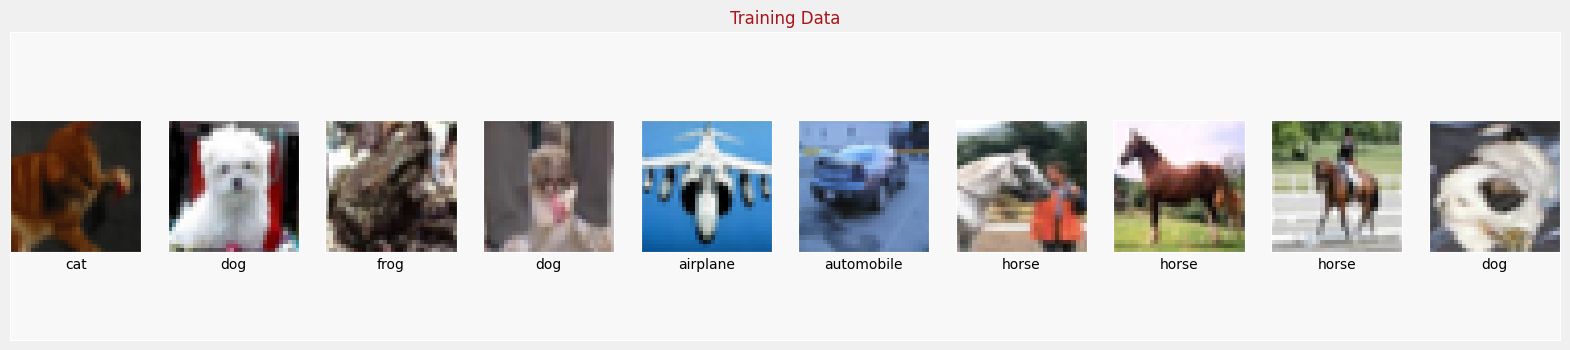

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

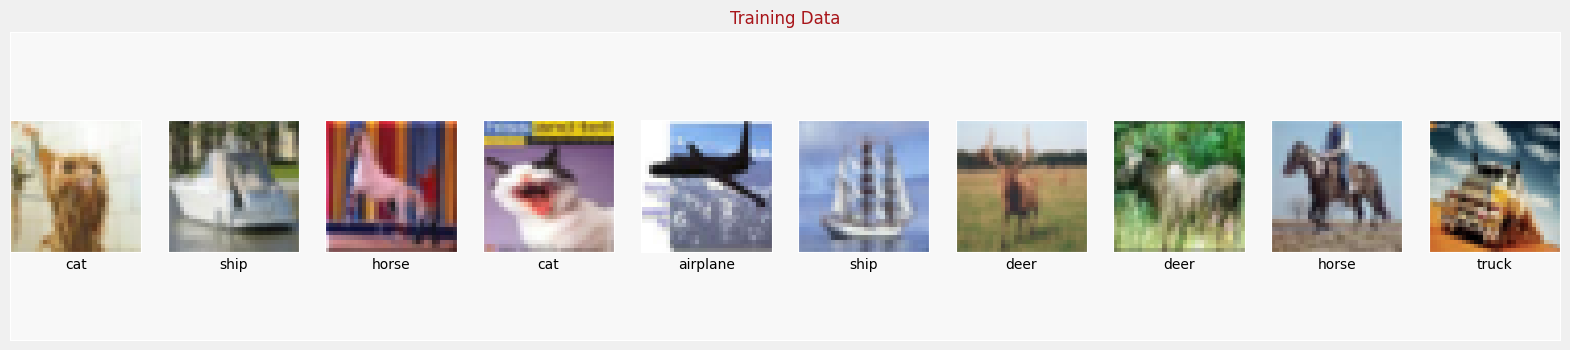

In [ ]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

### Preprocess Dataset
Here, we'll perform normalization on images in training and validation set.
- We'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network
We will be performing transfer learning on **ResNet50** available in Keras.
- We'll load pre-trained **imagenet weights** to the model.
- We'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Train the model

In [ ]:
EPOCHS = 25
BATCH_SIZE = 32

history = model.fit(
    train_X, training_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=550,
    validation_data=(valid_X, validation_labels),
    validation_steps=1
)

Epoch 1/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 63s 49ms/step - accuracy: 0.6924 - loss: 0.9348 - val_accuracy: 0.9688 - val_loss: 0.0999
Epoch 2/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9127 - loss: 0.2572 - val_accuracy: 1.0000 - val_loss: 0.0636
Epoch 3/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.9247 - loss: 0.2206 - val_accuracy: 1.0000 - val_loss: 0.0307
Epoch 4/25
  1/550 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.9688 - loss: 0.1363

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


550/550 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.9731 - loss: 0.0897 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 5/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.9691 - loss: 0.0979 - val_accuracy: 0.9688 - val_loss: 0.0555
Epoch 6/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9663 - loss: 0.0964 - val_accuracy: 1.0000 - val_loss: 0.0132
Epoch 7/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.9892 - loss: 0.0359 - val_accuracy: 0.9688 - val_loss: 0.0345
Epoch 8/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.9890 - loss: 0.0359 - val_accuracy: 1.0000 - val_loss: 0.0108
Epoch 9/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9862 - loss: 0.0405 - val_accuracy: 1.0000 - val_loss: 0.0355
Epoch 10/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.9918 - loss: 0.0255 - val_accuracy: 1.0000 - val_loss: 0.0142
Epoch 11/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.9954 - loss: 0.0165 - val_accur

## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=32)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9612 - loss: 0.1720


In [ ]:
from tensorflow.keras.optimizers import Adam

# New hyperparameters for experiment (b)
EPOCHS_2 = 15
BATCH_SIZE_2 = 64

# Rebuild a fresh copy of the same architecture
model2 = define_compile_model()   # this uses your ResNet50 + classifier structure

# Re-compile with new optimizer
model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    train_X, training_labels,
    epochs=EPOCHS_2,
    batch_size=BATCH_SIZE_2,
    validation_data=(valid_X, validation_labels)
)

test_loss2, test_acc2 = model2.evaluate(test_X, test_labels, verbose=0)
print("ResNet50 (Adam, bs=64, epochs=15) Test Accuracy:", test_acc2)


Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 150s 115ms/step - accuracy: 0.8250 - loss: 0.5196 - val_accuracy: 0.9205 - val_loss: 0.2420
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.9693 - loss: 0.0955 - val_accuracy: 0.9313 - val_loss: 0.2179
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.9791 - loss: 0.0650 - val_accuracy: 0.9170 - val_loss: 0.2856
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.9811 - loss: 0.0561 - val_accuracy: 0.9390 - val_loss: 0.2189
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.9836 - loss: 0.0497 - val_accuracy: 0.9386 - val_loss: 0.2306
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.9872 - loss: 0.0384 - val_accuracy: 0.9175 - val_loss: 0.3106
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.9884 - loss: 0.0338 - val_accuracy: 0.9324 - val_loss: 0.2645
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - accuracy: 0.9891 - loss: 0.0329 

NameError: name 'test_X' is not defined

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9610 - loss: 0.1731


### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

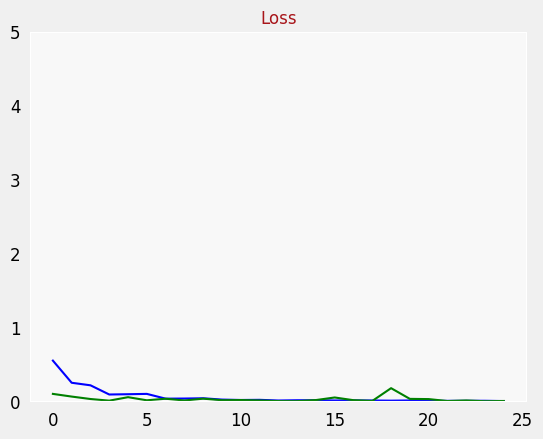

In [ ]:
plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

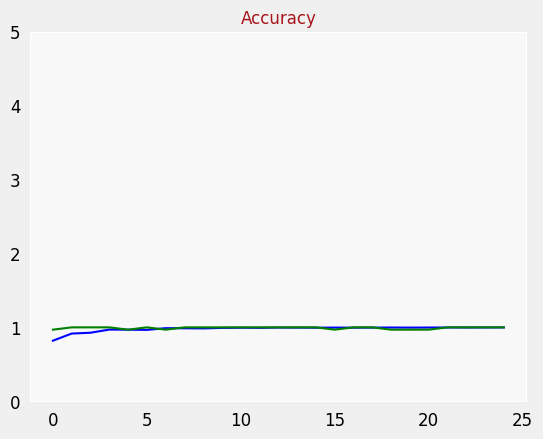

In [ ]:
plot_metrics("accuracy", "Accuracy")

In [ ]:
# --- Imports ---
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# --- 1. Prepare test data ---
# Resize CIFAR-10 test images from (32, 32, 3) → (224, 224, 3)
test_images_resnet = tf.image.resize(x_test, (224, 224))
test_images_resnet = preprocess_input(test_images_resnet)

# --- 2. Evaluate model performance ---
test_loss2, test_acc2 = model2.evaluate(test_images_resnet, y_test, verbose=1)

print("\n📊 ResNet50 (Adam, bs=64, epochs=15) Results")
print("Test Accuracy : {:.4f}".format(test_acc2))
print("Test Loss     : {:.4f}".format(test_loss2))

# --- 3. Plot accuracy and loss curves ---
def plot_metrics(history_obj, metric_name, title):
    plt.figure(figsize=(7,5))
    plt.plot(history_obj.history[metric_name], label='Train ' + metric_name, linewidth=2)
    plt.plot(history_obj.history['val_' + metric_name], label='Val ' + metric_name, linewidth=2, linestyle='--')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Plot Accuracy
plot_metrics(history2, "accuracy", "ResNet50 (Adam) - Accuracy per Epoch")

# Plot Loss
plot_metrics(history2, "loss", "ResNet50 (Adam) - Loss per Epoch")

# --- 4. Optional: Confusion Matrix ---
print("\nGenerating confusion matrix...")
y_pred = model2.predict(test_images_resnet)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.flatten()

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    'airplane','automobile','bird','cat','deer','do


SyntaxError: unterminated string literal (detected at line 46) (ipython-input-4057302711.py, line 46)

### Visualize predictions
We can take a look at the predictions on the validation set.

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


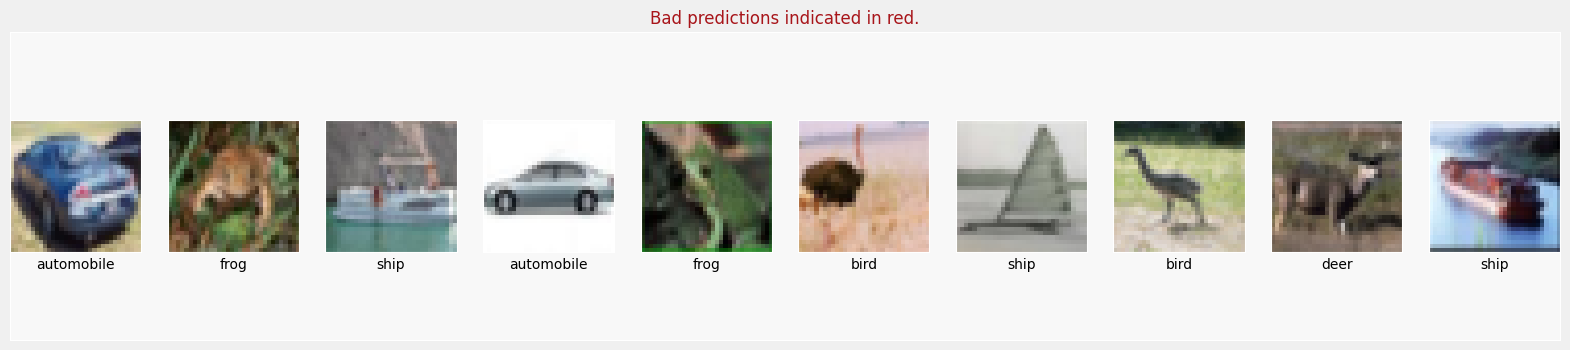

In [ ]:
probabilities = model.predict(valid_X, batch_size=32)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")